


# Import Libraries

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [17]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])


test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [18]:
train = datasets.MNIST('./', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./', train=False, download=True,transform=test_transforms)

# Dataloaders: Test/Train dataset

In [19]:
batch_size = 100
learning_rate = 0.05

In [20]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = batch_size, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data

torch.Size([100, 1, 28, 28])
torch.Size([100])


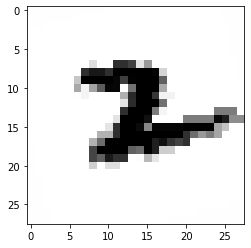

In [21]:
# # converting array into numpy from tensor
# train_data = train.train_data
# train_data = train.transform(train.train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[52].numpy().squeeze(), cmap='gray_r')


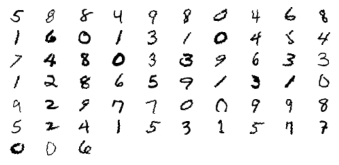

In [22]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Mean & Std Values to Normalize dataset

In [23]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


# Basic Model

In [24]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) # input_size = 26 output_size = 24 receptive_field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7       
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 22 output_size = 20 receptive_field = 9        
        
        
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 20 output_size = 10 receptive_field = 18

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 10 output_size = 8 receptive_field = 20
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 8 output_size = 6 receptive_field = 22
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 6 output_size = 4 receptive_field = 24
        
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(10),
        ) # input_size = 1 output_size = 1  receptive_field = 24
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)  
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [25]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             900
      BatchNorm2d-10           [-1, 10, 22, 22]              20
          Dropout-11           [-1, 10, 22, 22]               0
             ReLU-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             900
      BatchNorm2d-14           [-1

#Training & Testing

In [26]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
def train(model, device, train_loader, optimizer, epoch,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()
  train_epoch_end.append(train_acc[-1])
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [27]:
# from torch.optim.lr_scheduler import OneCycleLR
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)
# EPOCHS = 15
# for epoch in range(1,EPOCHS):
#     print("EPOCH:", epoch, "Learning Rate : ",scheduler.get_lr())
#     train(model, device, train_loader, optimizer, epoch, scheduler)
#     test(model, device, test_loader)


EPOCHS = 25


from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)


  0%|          | 0/600 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18968187272548676 Batch_id=599 Accuracy=82.28: 100%|██████████| 600/600 [00:17<00:00, 33.41it/s]

Epoch: 0 LR: [0.008151635943912883]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0739, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


Loss=0.03938493877649307 Batch_id=599 Accuracy=96.80: 100%|██████████| 600/600 [00:19<00:00, 31.43it/s] 

Epoch: 1 LR: [0.019888373733535303]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.06714629381895065 Batch_id=599 Accuracy=97.31: 100%|██████████| 600/600 [00:18<00:00, 32.30it/s] 

Epoch: 2 LR: [0.03717993576588072]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.07298417389392853 Batch_id=599 Accuracy=97.75: 100%|██████████| 600/600 [00:18<00:00, 32.17it/s]  

Epoch: 3 LR: [0.05703514410512061]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.10842180997133255 Batch_id=599 Accuracy=97.89: 100%|██████████| 600/600 [00:18<00:00, 32.39it/s]  


Epoch: 4 LR: [0.07601934889229382]


  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.029107103124260902 Batch_id=599 Accuracy=98.17: 100%|██████████| 600/600 [00:18<00:00, 32.94it/s]

Epoch: 5 LR: [0.09084857067069077]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.061545923352241516 Batch_id=599 Accuracy=98.19: 100%|██████████| 600/600 [00:18<00:00, 32.79it/s] 

Epoch: 6 LR: [0.09895757901716772]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.04593171924352646 Batch_id=599 Accuracy=98.32: 100%|██████████| 600/600 [00:17<00:00, 33.39it/s]  

Epoch: 7 LR: [0.09979737228037476]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.017987044528126717 Batch_id=599 Accuracy=98.44: 100%|██████████| 600/600 [00:18<00:00, 31.69it/s] 

Epoch: 8 LR: [0.098194168198951]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.0525934062898159 Batch_id=599 Accuracy=98.55: 100%|██████████| 600/600 [00:18<00:00, 31.61it/s]   

Epoch: 9 LR: [0.09504197032548385]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.019891373813152313 Batch_id=599 Accuracy=98.59: 100%|██████████| 600/600 [00:19<00:00, 31.56it/s] 


Epoch: 10 LR: [0.09044209289326356]


  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.008698484860360622 Batch_id=599 Accuracy=98.58: 100%|██████████| 600/600 [00:18<00:00, 31.85it/s] 

Epoch: 11 LR: [0.0845423797477535]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.06847406178712845 Batch_id=599 Accuracy=98.61: 100%|██████████| 600/600 [00:18<00:00, 31.65it/s]  

Epoch: 12 LR: [0.07753245252375043]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.10230755060911179 Batch_id=599 Accuracy=98.69: 100%|██████████| 600/600 [00:18<00:00, 31.75it/s]  

Epoch: 13 LR: [0.06963761605002122]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.024864088743925095 Batch_id=599 Accuracy=98.77: 100%|██████████| 600/600 [00:18<00:00, 32.09it/s] 

Epoch: 14 LR: [0.061111616866724575]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.07540528476238251 Batch_id=599 Accuracy=98.84: 100%|██████████| 600/600 [00:18<00:00, 31.77it/s]  

Epoch: 15 LR: [0.05222848760282715]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.07473120838403702 Batch_id=599 Accuracy=98.83: 100%|██████████| 600/600 [00:18<00:00, 31.60it/s]  

Epoch: 16 LR: [0.043273739341933716]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.025367742404341698 Batch_id=599 Accuracy=98.88: 100%|██████████| 600/600 [00:18<00:00, 31.63it/s] 

Epoch: 17 LR: [0.03453518506114079]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.008950861170887947 Batch_id=599 Accuracy=98.88: 100%|██████████| 600/600 [00:18<00:00, 32.02it/s] 

Epoch: 18 LR: [0.026293689085139474]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.06464513391256332 Batch_id=599 Accuracy=99.00: 100%|██████████| 600/600 [00:18<00:00, 32.26it/s]  

Epoch: 19 LR: [0.018814139875723952]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


Loss=0.009083078242838383 Batch_id=599 Accuracy=99.02: 100%|██████████| 600/600 [00:18<00:00, 32.06it/s] 

Epoch: 20 LR: [0.012336936298678384]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9955/10000 (99.55%)

EPOCH: 21


Loss=0.02928898297250271 Batch_id=599 Accuracy=99.02: 100%|██████████| 600/600 [00:18<00:00, 31.97it/s]  


Epoch: 21 LR: [0.007070261006429881]


  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9951/10000 (99.51%)

EPOCH: 22


Loss=0.016487596556544304 Batch_id=599 Accuracy=99.14: 100%|██████████| 600/600 [00:19<00:00, 31.49it/s] 

Epoch: 22 LR: [0.0031833892763061954]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9956/10000 (99.56%)

EPOCH: 23


Loss=0.01620033010840416 Batch_id=599 Accuracy=99.14: 100%|██████████| 600/600 [00:18<00:00, 32.02it/s]  

Epoch: 23 LR: [0.0008012483638421984]



  0%|          | 0/600 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9957/10000 (99.57%)

EPOCH: 24


Loss=0.01871608942747116 Batch_id=599 Accuracy=99.15: 100%|██████████| 600/600 [00:18<00:00, 32.00it/s]  

Epoch: 24 LR: [4.022379965622214e-07]



Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)



# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

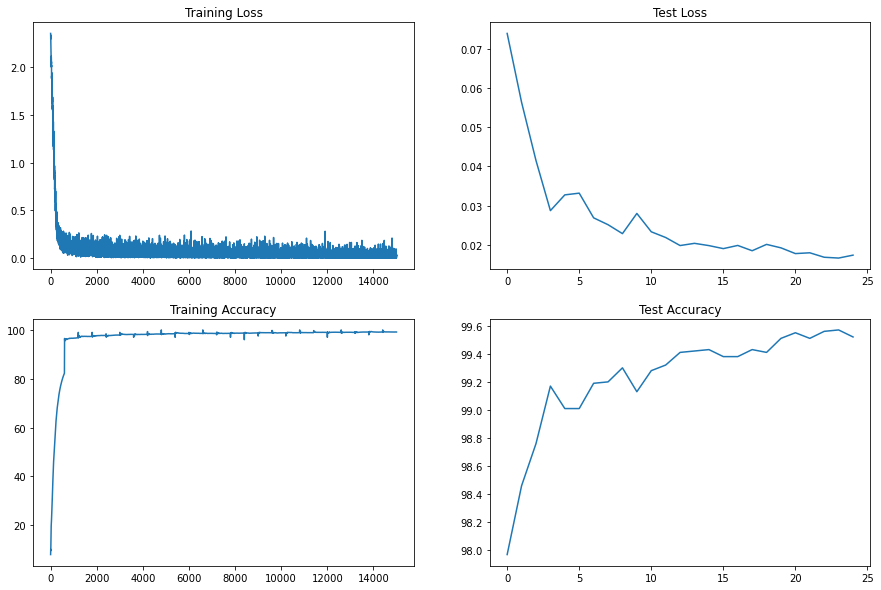

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

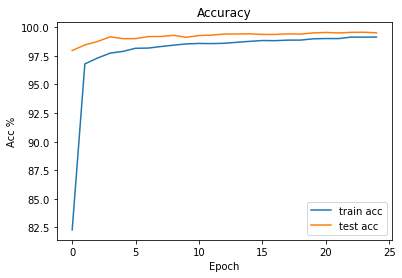

Best Training Accuracy :  98.995 %
Best Test Accuracy :  99.51 %


In [29]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('Accuracy')
plt.ylabel('Acc %')
plt.xlabel('Epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.show()
print("Best Training Accuracy : ",max(train_epoch_end[:20]),"%")
print("Best Test Accuracy : ",max(test_acc[:20]),"%")



### **Target**

1. Achieve a Model Testing  accuracy of  99.4%  at least 4 times .
2. Have a limit of 10k parameters in model.
3. Have a limit of 15 Epochs .

### **<u>Model 2</u>**


1. Set the structure of model.
2. Understanding the Statistics of Image and eye-balling the image.
3. Building model with Relu at every layer and softmax.
4. Trying various learning rate and batch size to obtain.
5. Trying to obtain constant increase in train and test accuracy.
6. Not undertrained and not overfitting.
7. Let's see the model performance for 20 epochs to understand where it is going.

### **Result**


Total params: 11,120
Trainable params: 11,120
Non-trainable params: 0


Best Training Accuracy :  98.93166666666667 %
Best Test Accuracy :  98.83 %

### Analysis

1. A constant increase in number of kernel or constant number of kernels per block.
2. Mnist is a simple dataset and does not need very large number of kernels or parameters.
3. Training Accuracy was not constant if no of kernels used is intermitently placed in model. This leads to a very zig-zag loss and test accuracy curve which was avoided and was made smooths.
4. 3 - 4 models were tested with different learning rate (0.15 - 0.35) and batch size(32 - 128) to achieve a acceptable model to work on.